<a href="https://colab.research.google.com/github/nazaninbondarian/MachineLearning2024/blob/main/Project/Project_exm5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sys
sys.path.append('../src')

In [2]:
pip install pykoopman

In [3]:
%matplotlib inline
import pykoopman as pk
from pykoopman.common.examples import vdp_osc, rk4, square_wave  # required for example system
import matplotlib.pyplot as plt
import numpy as np
import numpy.random as rnd
np.random.seed(76)  # for reproducibility

import warnings
warnings.filterwarnings('ignore')

In [4]:
n_states = 2 # Number of states
n_inputs = 1 # Number of control inputs
dT = 0.01    # Timestep
n_traj = 200  # Number of trajectories
n_int = 1000  # Integration length

In [5]:
# Time vector
t = np.arange(0, n_int*dT, dT)

# Uniform random distributed forcing in [-1, 1]
u = 2*rnd.random([n_int, n_traj])-1

# Uniform distribution of initial conditions
x = 2*rnd.random([n_states, n_traj])-1

# Init
X = np.zeros((n_states, n_int*n_traj))
Y = np.zeros((n_states, n_int*n_traj))
U = np.zeros((n_inputs, n_int*n_traj))

# Integrate
for step in range(n_int):
    y = rk4(0, x, u[step, :], dT, vdp_osc)
    X[:, (step)*n_traj:(step+1)*n_traj] = x
    Y[:, (step)*n_traj:(step+1)*n_traj] = y
    U[:, (step)*n_traj:(step+1)*n_traj] = u[step, :]
    x = y

[Text(0, 0.5, '$x_2$'), Text(0.5, 0, '$t$')]

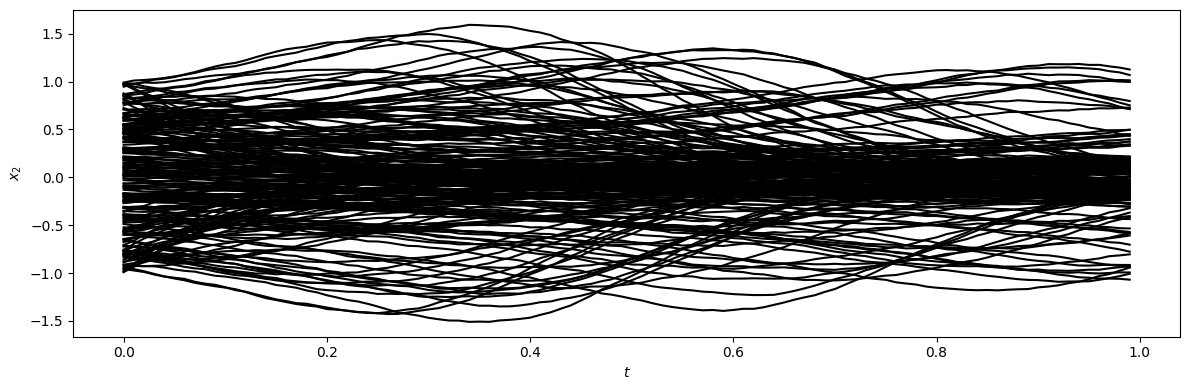

In [6]:
# Visualize first 100 steps of the training data
fig, axs = plt.subplots(1, 1, tight_layout=True, figsize=(12, 4))
for traj_idx in range(n_traj):
    x = X[:, traj_idx::n_traj]
    axs.plot(t[0:100], x[1, 0:100], 'k')
axs.set(
        ylabel=r'$x_2$',
        xlabel=r'$t$')

In [7]:
EDMDc = pk.regression.EDMDc()
centers = np.random.uniform(-1,1,(2,5))
RBF = pk.observables.RadialBasisFunction(
    rbf_type="thinplate",
    n_centers=centers.shape[1],
    centers=centers,
    kernel_width=1,
    polyharmonic_coeff=1,
    include_state=True,
)

model = pk.Koopman(observables=RBF, regressor=EDMDc)
model.fit(X.T, y=Y.T, u=U.T)

Koopman(observables=RadialBasisFunction(centers=array([[ 0.34615486,  0.1798453 ,  0.7414451 , -0.62035003, -0.79566579],
       [-0.81285059,  0.3451299 , -0.9000197 , -0.5639517 ,  0.55688281]]),
                                        kernel_width=1, n_centers=5,
                                        polyharmonic_coeff=1,
                                        rbf_type='thinplate'),
        regressor=EDMDc())

In [18]:
n_int = 2000  # Integration length
t = np.arange(0, n_int*dT, dT)
u = np.array([-square_wave(step//2+1) for step in range(n_int)])
x = np.array([0.5, 0.5])

# Integrate nonlinear system
Xtrue = np.zeros((n_states, n_int))
Xtrue[:, 0] = x
for step in range(1, n_int, 1):
    y = rk4(0, Xtrue[:, step-1].reshape(n_states,1), u[np.newaxis, step-1], dT, vdp_osc)
    Xtrue[:, step] = y.reshape(n_states,)

In [19]:
# Multi-step prediction with Koopman/EDMDc model
Xkoop = model.simulate(x, u[:, np.newaxis], n_steps=n_int-1)
Xkoop = np.vstack([x[np.newaxis,:], Xkoop]) # add initial condition to simulated data for comparison below

Text(0.5, 1.0, 'L2 norm error = 22.91839891793212')

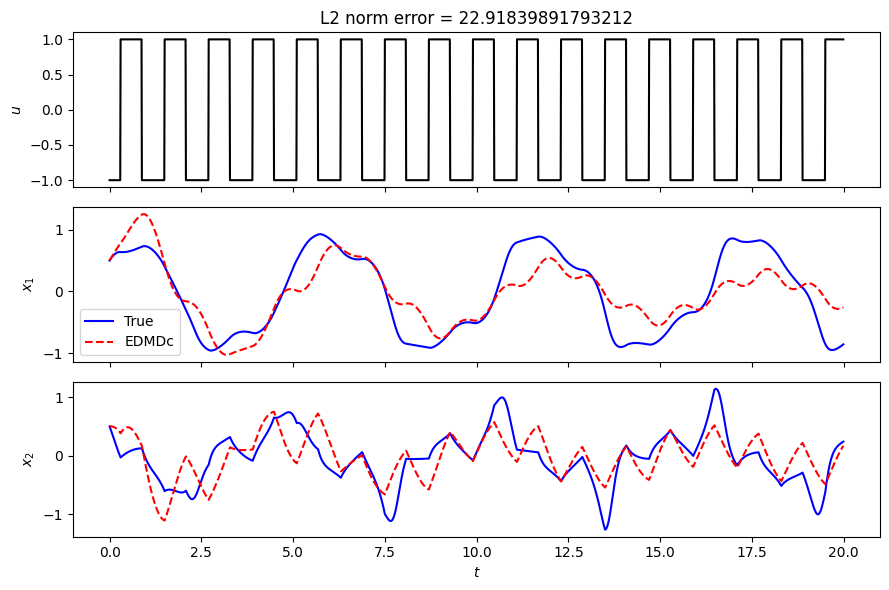

In [20]:
fig, axs = plt.subplots(3, 1, sharex=True, tight_layout=True, figsize=(9, 6))
axs[0].plot(t, u, '-k')
axs[0].set(ylabel=r'$u$')
axs[1].plot(t, Xtrue[0, :], '-', color='b', label='True')
axs[1].plot(t, Xkoop[:, 0], '--r', label='EDMDc')
axs[1].set(ylabel=r'$x_1$')
axs[2].plot(t, Xtrue[1, :], '-', color='b', label='True')
axs[2].plot(t, Xkoop[:, 1], '--r', label='EDMDc')
axs[2].set(
        ylabel=r'$x_2$',
        xlabel=r'$t$')

axs[1].legend()

err = np.linalg.norm(Xtrue - Xkoop.T)
axs[0].set_title(f"L2 norm error = {err}")

In [17]:
print('Shape of:')
print('A: ',model.A.shape,)
print('B: ',model.B.shape,)
print('C: ',model.C.shape,)
print('W: ',model.W.shape,)

Shape of:
A:  (7, 7)
B:  (7, 1)
C:  (2, 7)
W:  (2, 7)
